In [909]:
# train = pd.read_csv("./train.csv")
# train = train.dropna(subset=["賃料"])
# train = train.drop(20926)
# train = train.drop(20231)
# train = train.drop(20427)
# train = train.drop(5775)
# train_x = train.drop("賃料",axis=1)
# train_y = train["賃料"]
# test = pd.read_csv("./test.csv")
train = pd.read_csv("./train_with_ido.csv")
train = train.dropna(subset=["賃料"])
train = train.drop(20926)
train = train.drop(20231)
train = train.drop(20427)
train = train.drop(5775)
train = train.drop("Unnamed: 0",axis=1)
train_x = train.drop("賃料",axis=1)
train_y = train["賃料"]
test = pd.read_csv("./test_with_ido.csv")
test = test.drop("Unnamed: 0",axis=1)
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import pandas as pd
import numpy as np
from scipy import stats as st
import re
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import probplot
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

import math

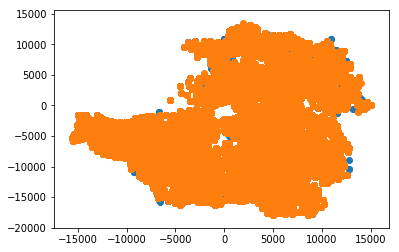

In [957]:
ido = test["ido"].values
keido = test["keido"].values
x = [0 for i in range(len(ido))]
y = [0 for i in range(len(ido))]
for i in range(len(ido)):
    a,b = calc_xy(ido[i],keido[i], 35.681236,139.767125)
    x[i] = a
    y[i] = b
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x,y)

ido = train["ido"].values
keido = train["keido"].values
x = [0 for i in range(len(ido))]
y = [0 for i in range(len(ido))]
for i in range(len(ido)):
    a,b = calc_xy(ido[i],keido[i], 35.681236,139.767125)
    x[i] = a
    y[i] = b
ax.scatter(x,y)

In [966]:
class homes_in_nkm:
    def __init__(self):
        pass
    def fit(self,x,y):
        return self
    def transform(self,x):
        r = 500
        resolution = 50
        
        ido = x["ido"].values
        keido = x["keido"].values
        pos_x = [0 for i in range(len(ido))]
        pos_y = [0 for i in range(len(ido))]
        buf =  [0 for i in range(len(ido))]
        for i in range(len(ido)):
            a,b = ido_calc_xy(ido[i],keido[i],35.681236,139.767125)
            pos_x[i] = a
            pos_y[i] = b
        grid_num = 40000//resolution
        bucket = [[0 for i in range(grid_num)] for j in range(grid_num)]
        around = (2*r)//resolution
        for i in range(len(ido)):
            a = int(pos_x[i]//resolution)+grid_num//2
            b = int(pos_y[i]//resolution)+grid_num//2
            bucket[a][b] += 1
        for i in range(len(ido)):
            a = int(pos_x[i]//resolution)+grid_num//2
            b = int(pos_y[i]//resolution)+grid_num//2
            temp = 0
            for j in range(around+1):
                for k in range(around+1):
                    temp += bucket[a+j-around//2][b+k-around//2]
            buf[i] = temp


        return x.assign(house_in_1km=buf)
temp = homes_in_nkm()
fuga = temp.transform(train)

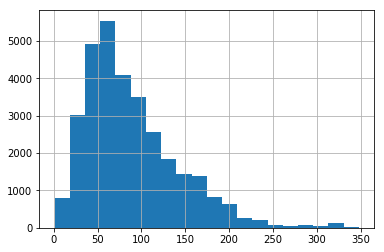

In [967]:
fuga["house_in_1km"].hist(bins=20)

In [959]:
def ido_calc_xy(phi_deg, lambda_deg, phi0_deg, lambda0_deg):
    """ 緯度経度を平面直角座標に変換する
    - input:
        (phi_deg, lambda_deg): 変換したい緯度・経度[度]（分・秒でなく小数であることに注意）
        (phi0_deg, lambda0_deg): 平面直角座標系原点の緯度・経度[度]（分・秒でなく小数であることに注意）
    - output:
        x: 変換後の平面直角座標[m]
        y: 変換後の平面直角座標[m]
    """
    # 緯度経度・平面直角座標系原点をラジアンに直す
    phi_rad = np.deg2rad(phi_deg)
    lambda_rad = np.deg2rad(lambda_deg)
    phi0_rad = np.deg2rad(phi0_deg)
    lambda0_rad = np.deg2rad(lambda0_deg)

    # 補助関数
    def A_array(n):
        A0 = 1 + (n**2)/4. + (n**4)/64.
        A1 = -     (3./2)*( n - (n**3)/8. - (n**5)/64. ) 
        A2 =     (15./16)*( n**2 - (n**4)/4. )
        A3 = -   (35./48)*( n**3 - (5./16)*(n**5) )
        A4 =   (315./512)*( n**4 )
        A5 = -(693./1280)*( n**5 )
        return np.array([A0, A1, A2, A3, A4, A5])

    def alpha_array(n):
        a0 = np.nan # dummy
        a1 = (1./2)*n - (2./3)*(n**2) + (5./16)*(n**3) + (41./180)*(n**4) - (127./288)*(n**5)
        a2 = (13./48)*(n**2) - (3./5)*(n**3) + (557./1440)*(n**4) + (281./630)*(n**5)
        a3 = (61./240)*(n**3) - (103./140)*(n**4) + (15061./26880)*(n**5)
        a4 = (49561./161280)*(n**4) - (179./168)*(n**5)
        a5 = (34729./80640)*(n**5)
        return np.array([a0, a1, a2, a3, a4, a5])

    # 定数 (a, F: 世界測地系-測地基準系1980（GRS80）楕円体)
    m0 = 0.9999 
    a = 6378137.
    F = 298.257222101

    # (1) n, A_i, alpha_iの計算
    n = 1. / (2*F - 1)
    A_array = A_array(n)
    alpha_array = alpha_array(n)

    # (2), S, Aの計算
    A_ = ( (m0*a)/(1.+n) )*A_array[0] # [m]
    S_ = ( (m0*a)/(1.+n) )*( A_array[0]*phi0_rad + np.dot(A_array[1:], np.sin(2*phi0_rad*np.arange(1,6))) ) # [m]

    # (3) lambda_c, lambda_sの計算
    lambda_c = np.cos(lambda_rad - lambda0_rad)
    lambda_s = np.sin(lambda_rad - lambda0_rad)

    # (4) t, t_の計算
    t = np.sinh( np.arctanh(np.sin(phi_rad)) - ((2*np.sqrt(n)) / (1+n))*np.arctanh(((2*np.sqrt(n)) / (1+n)) * np.sin(phi_rad)) )
    t_ = np.sqrt(1 + t*t)

    # (5) xi', eta'の計算
    xi2  = np.arctan(t / lambda_c) # [rad]
    eta2 = np.arctanh(lambda_s / t_)

    # (6) x, yの計算
    x = A_ * (xi2 + np.sum(np.multiply(alpha_array[1:],
                                       np.multiply(np.sin(2*xi2*np.arange(1,6)),
                                                   np.cosh(2*eta2*np.arange(1,6)))))) - S_ # [m]
    y = A_ * (eta2 + np.sum(np.multiply(alpha_array[1:],
                                        np.multiply(np.cos(2*xi2*np.arange(1,6)),
                                                    np.sinh(2*eta2*np.arange(1,6)))))) # [m]
    # return
    return x, y # [m]

In [908]:
train.groupby("方角",as_index=False).apply(lambda d: (d["賃料"]).mean())

0    126057.842319
1    127517.737320
2    134986.058113
3    114153.569777
4    131210.768238
5    126737.894481
6    113991.111311
7    116873.638509
dtype: float64

In [449]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = train.drop(20926)
train = train.drop(20231)
train = train.drop(20427)
train = train.drop(5775)

In [669]:
temp = train["周辺環境"].values
p2 = re.compile(r"【.*】")
d = set()
for i in range(len(temp)):
    txt = temp[i]
    if txt == txt:
        txt = re.sub(r"／","",txt)
        txt = txt.split()
        for t in txt:
            if p2.match(t):
                d.add(t)
print(d)

{'【大学】', '【飲食店】', '【月極駐車場】', '【ドラッグストア】', '【クリーニング】', '【銀行】', '【幼稚園・保育園】', '【総合病院】', '【学校】', '【レンタルビデオ】', '【図書館】', '【病院】', '【小学校】', '【コインパーキング】', '【スーパー】', '【コンビニ】', '【公園】', '【デパート】', '【郵便局】'}


In [678]:
train.query("賃料>150000").count()

id        6113
賃料        6113
所在地       6113
アクセス      6113
間取り       6113
築年数       6113
方角        5835
面積        6113
所在階       6113
バス・トイレ    6099
キッチン      6079
放送・通信     5717
室内設備      6106
駐車場       5481
周辺環境      4467
建物構造      6113
契約期間      4869
dtype: int64

In [676]:
train.query("id==240")["アクセス"]

239    西武池袋線\t大泉学園駅\t/バス(19分)長久保下車徒歩2分\t\t東武東上線\t和光市駅...
Name: アクセス, dtype: object

In [677]:
th = 150000
train.query("賃料>@th").describe()

,id,賃料
count,6113.000000,6.113000e+03
mean,15574.001799,2.232007e+05
std,9135.919201,1.054047e+05
min,6.000000,1.502000e+05
25%,7651.000000,1.690000e+05
50%,15378.000000,1.940000e+05
75%,23614.000000,2.450000e+05
max,31464.000000,2.500000e+06


In [558]:
t1 = train.query("賃料>@th")["賃料"].mean()
t1 = [t1 for i in range(len(train.query("賃料>@th").values))]
print(t1[:3])
s1 = mean_squared_error(t1,train.query("賃料>@th")["賃料"].values)
print(np.sqrt(s1))

[748439.0243902439, 748439.0243902439, 748439.0243902439]
291020.66381922073


In [559]:
t1 = train.query("賃料>@th")["賃料"].median()
t1 = [t1 for i in range(len(train.query("賃料>@th").values))]
print(t1[:3])
s1 = mean_squared_error(t1,train.query("賃料>@th")["賃料"].values)
print(np.sqrt(s1))

[650000.0, 650000.0, 650000.0]
307218.60017369216


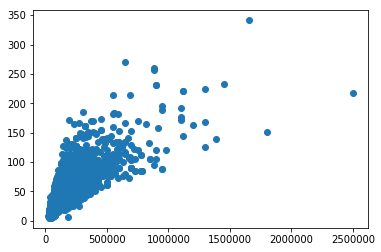

In [562]:
hoge = parse_area_size()
hoge = hoge.transform(train)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(hoge["賃料"],hoge["mf_areasize"])

6141
25091
234


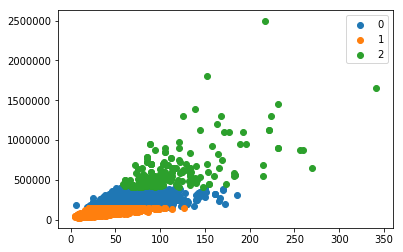

In [581]:
kmeans = KMeans(n_clusters=3)
data = hoge[["mf_areasize","賃料"]].values
kmeans.fit(data)
cs = [[] for i in range(max(kmeans.labels_) +1)]
for i in range(len(data)):
    cs[kmeans.labels_[i]].append(data[i])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ind = 0
for c in cs:
    print(len(c))
    ct = np.array(c).T
    ax.scatter(ct[0],ct[1],label=ind)
    ind += 1
    ax.legend()

In [542]:
train.query("賃料<=@th").describe()

,id,賃料
count,30840.000000,30840.000000
mean,15726.244293,111682.436543
std,9084.397972,49890.792874
min,1.000000,25000.000000
25%,7856.750000,75500.000000
50%,15716.500000,100500.000000
75%,23585.250000,134000.000000
max,31470.000000,300000.000000


In [599]:
pat = "駐車場\t.{,1}有"
for i in range(10,20):
    txt = train["駐車場"].values[i]
    if txt == txt:
        print(txt)
        print(re.match(pat,txt))

駐車場	空有	32,400円(税込)	駐輪場	空有	バイク置き場	空有
<re.Match object; span=(0, 6), match='駐車場\t空有'>
駐輪場	無	バイク置き場	無
None
駐輪場	空有	バイク置き場	無
None
駐車場	近隣	27,000円(税込)	距離500m	駐輪場	無	バイク置き場	無
None
駐輪場	空有	バイク置き場	空有	駐車場	近隣	23,000円	距離150m
None
駐車場	近隣	15,120円	距離200m
None
駐輪場	空有
None
駐車場	無	駐輪場	無	バイク置き場	無
None


In [602]:
train["室内設備"].head()

0    エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...
1    エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...
2    エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...
3    エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...
4                  バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水
Name: 室内設備, dtype: object

In [530]:
hoge.groupby(["south","east"]).mean().index.values

array([(0.0, 0.0), (0.0, 0.5), (0.0, 1.0), (0.5, 0.0), (0.5, 0.5),
       (1.0, 0.0)], dtype=object)

In [601]:
train["周辺環境"].unique()

array(['【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\t【飲食店】 378m\t【スーパー】 311m\t【コンビニ】 588m\t【スーパー】 1062m\t【ドラッグストア】 956m\t【郵便局】 1246m',
       '【スーパー】 1283m',
       '【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m', ...,
       '【小学校】 504m\t【学校】 233m\t【幼稚園・保育園】 289m\t【郵便局】 753m\t【図書館】 1623m\t【公園】 749m\t【病院】 281m',
       '【スーパー】 458m\t【スーパー】 540m\t【コンビニ】 131m\t【コンビニ】 265m\t【公園】 1300m',
       '【スーパー】 485m\t【スーパー】 1051m\t【コンビニ】 476m\t【コンビニ】 759m'],
      dtype=object)

In [709]:
train.head(20)

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間
3,4,150000,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。
4,5,74000,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間
5,6,160000,東京都荒川区南千住５丁目,常磐線快速\t南千住駅\t徒歩2分\t\t都電荒川線\t三ノ輪橋駅\t徒歩10分\t\t日比...,2LDK,7年6ヶ月,東,50.8m2,6階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\t独立キッチン,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,"駐輪場\t空有\t駐車場\t近隣\t27,000円(税込)\t距離150m\tバイク置き場\t無",【スーパー】 251m\t【コンビニ】 376m,RC（鉄筋コンクリート）,2年間
6,7,78500,東京都練馬区東大泉３丁目,西武池袋線\t大泉学園駅\t徒歩4分\t\t西武池袋線\t保谷駅\t徒歩25分\t\t東武東...,1K,10年5ヶ月,南,23.82m2,6階／8階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCATV／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,"駐輪場\t空有\t駐車場\t近隣\t16,000円(税込)\t距離200m\tバイク置き場\t無",【スーパー】 812m\t【コンビニ】 149m\t【コンビニ】 942m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間
7,8,115000,東京都目黒区鷹番１丁目,東急東横線\t学芸大学駅\t徒歩7分\t\t東急東横線\t都立大学駅\t徒歩16分\t\t東...,1K,14年4ヶ月,NaN,32.32m2,1階／6階建,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン,光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,NaN,【スーパー】 334m\t【スーパー】 562m\t【スーパー】 694m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間
8,9,184327,東京都文京区向丘１丁目,南北線\t東大前駅\t徒歩3分\t\t都営三田線\t白山(東京都)駅\t徒歩10分\t\t千...,2DK,44年8ヶ月,北西,65.59m2,4階／9階建,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t洗面台独立,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯,NaN,エアコン付\tバルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t都市ガス,駐車場\t無,NaN,SRC（鉄骨鉄筋コンクリート）,2年間
9,10,76000,東京都板橋区板橋４丁目,埼京線\t板橋駅\t徒歩8分\t\t都営三田線\t新板橋駅\t徒歩4分\t\t東武東上線\t...,1DK,38年9ヶ月,南東,30.3m2,2階／3階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t洗面台独立,ガスコンロ／\tコンロ2口／\t給湯,光ファイバー／\tCATV,エアコン付\tバルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t都市ガス,駐車場\t無,NaN,鉄骨造,2年間


In [682]:
txt = train["所在地"][0]
print(txt)

東京都北区滝野川３丁目


In [693]:
geo = pd.read_csv("geo.csv")

In [694]:
geo.head()

,都道府県コード,都道府県名,市区町村コード,市区町村名,大字町丁目コード,大字町丁目名,緯度,経度,原典資料コード,大字・字・丁目区分コード
0,13,東京都,13101,千代田区,131010001002,内幸町二丁目,35.670812,139.754182,0,3
1,13,東京都,13101,千代田区,131010001001,内幸町一丁目,35.670839,139.758119,0,3
2,13,東京都,13101,千代田区,131010002003,霞が関三丁目,35.671825,139.746988,0,3
3,13,東京都,13101,千代田区,131010003000,北の丸公園,35.691555,139.751639,0,1
4,13,東京都,13101,千代田区,131010004001,富士見一丁目,35.697871,139.746978,0,3


In [718]:
geo = geo[["市区町村名","大字町丁目名","緯度","経度"]]

In [719]:
geo.head()

,市区町村名,大字町丁目名,緯度,経度
0,千代田区,内幸町二丁目,35.670812,139.754182
1,千代田区,内幸町一丁目,35.670839,139.758119
2,千代田区,霞が関三丁目,35.671825,139.746988
3,千代田区,北の丸公園,35.691555,139.751639
4,千代田区,富士見一丁目,35.697871,139.746978


In [774]:
geo.query("市区町村名 == '北区' and 大字町丁目名 == '滝野川三丁目'").values[0][2]

35.748593

In [704]:
temp = geo["大字町丁目名"].str.contains("十")

In [775]:
num_kanji = {"０":"零","１":"一","２":"二","３":"三","４":"四","５":"五","６":"六","７":"七","８":"八","９":"九"}

In [801]:
def address_of_it_(x):
    pat = re.compile(r"東京都.+区")
    p2 = re.compile(r"区.+?[０-９]丁目")
    p3 = re.compile(r"区.+?町")
    p4 = re.compile(r"区.+")
    p5 = re.compile(r"[０-９]")
    dist = ["" for i in range(len(x.values))]
    area = ["" for i in range(len(x.values))]
    tmp = x["所在地"].values
    for i in range(len(tmp)):
        m = pat.search(tmp[i])
        dist[i] = m[0][3:]
        m = p2.search(tmp[i])
        if m:
            area[i] = m[0][1:]
        else:
            m = p3.search(tmp[i])
            if m:
                area[i] = m[0][1:]
            else:
                m = p4.search(tmp[i])
                if m:
                    area[i] = m[0][1:]
        m = p5.search(area[i])
        if m:
            loc = m.start()
            num = num_kanji[m[0]]
            area[i] = area[i][0:loc]+num+area[i][loc+1:]
    return dist,area

class extract_district:
    def __init__(self):
        pass
    def fit(self,x,y):
        return self
    def transform(self,x):
        dist,area = address_of_it_(x)
        hoge = x.copy()
        hoge = hoge.drop("所在地",axis = 1)
        hoge = hoge.assign(district=dist)
        hoge = hoge.assign(city = area)
        return hoge
temp = extract_district()
hoge = temp.transform(train)
dist = hoge["district"]
city = hoge["city"]

dist = dist.values
city = city.values
ans = []

In [802]:
hoge.head(20)

,id,賃料,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,district,city
0,1,75000,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間,北区,滝野川三丁目
1,2,76000,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間,中央区,月島三丁目
2,3,110000,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間,渋谷区,笹塚二丁目
3,4,150000,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。,杉並区,高円寺南二丁目
4,5,74000,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間,葛飾区,金町三丁目
5,6,160000,常磐線快速\t南千住駅\t徒歩2分\t\t都電荒川線\t三ノ輪橋駅\t徒歩10分\t\t日比...,2LDK,7年6ヶ月,東,50.8m2,6階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\t独立キッチン,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,"駐輪場\t空有\t駐車場\t近隣\t27,000円(税込)\t距離150m\tバイク置き場\t無",【スーパー】 251m\t【コンビニ】 376m,RC（鉄筋コンクリート）,2年間,荒川区,南千住五丁目
6,7,78500,西武池袋線\t大泉学園駅\t徒歩4分\t\t西武池袋線\t保谷駅\t徒歩25分\t\t東武東...,1K,10年5ヶ月,南,23.82m2,6階／8階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCATV／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,"駐輪場\t空有\t駐車場\t近隣\t16,000円(税込)\t距離200m\tバイク置き場\t無",【スーパー】 812m\t【コンビニ】 149m\t【コンビニ】 942m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間,練馬区,東大泉三丁目
7,8,115000,東急東横線\t学芸大学駅\t徒歩7分\t\t東急東横線\t都立大学駅\t徒歩16分\t\t東...,1K,14年4ヶ月,NaN,32.32m2,1階／6階建,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン,光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,NaN,【スーパー】 334m\t【スーパー】 562m\t【スーパー】 694m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間,目黒区,鷹番一丁目
8,9,184327,南北線\t東大前駅\t徒歩3分\t\t都営三田線\t白山(東京都)駅\t徒歩10分\t\t千...,2DK,44年8ヶ月,北西,65.59m2,4階／9階建,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t洗面台独立,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯,NaN,エアコン付\tバルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t都市ガス,駐車場\t無,NaN,SRC（鉄骨鉄筋コンクリート）,2年間,文京区,向丘一丁目
9,10,76000,埼京線\t板橋駅\t徒歩8分\t\t都営三田線\t新板橋駅\t徒歩4分\t\t東武東上線\t...,1DK,38年9ヶ月,南東,30.3m2,2階／3階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t洗面台独立,ガスコンロ／\tコンロ2口／\t給湯,光ファイバー／\tCATV,エアコン付\tバルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t都市ガス,駐車場\t無,NaN,鉄骨造,2年間,板橋区,板橋四丁目


In [777]:
for i in range(len(dist)):
    di = dist[i]
    ci = city[i]
    ret = geo.query("市区町村名 == @di and 大字町丁目名 == @ci").values
    if len(ret) == 0:
        ans.append([np.nan,np.nan])
    else:
        ido = ret[0][2]
        keido = ret[0][3]
        ans.append([ido,keido])

In [786]:
def address_of_it_(x):
    pat = re.compile(r"東京都.+区")
    p2 = re.compile(r"区.+?[０-９]丁目")
    p3 = re.compile(r"区.+?町")
    p4 = re.compile(r"区.+")
    p5 = re.compile(r"[０-９]")
    dist = ["" for i in range(len(x.values))]
    area = ["" for i in range(len(x.values))]
    tmp = x["所在地"].values
    for i in range(len(tmp)):
        m = pat.search(tmp[i])
        dist[i] = m[0][3:]
        m = p2.search(tmp[i])
        if m:
            area[i] = m[0][1:]
        else:
            m = p3.search(tmp[i])
            if m:
                area[i] = m[0][1:]
            else:
                m = p4.search(tmp[i])
                if m:
                    area[i] = m[0][1:]
        m = p5.search(area[i])
        if m:
            loc = m.start()
            num = num_kanji[m[0]]
            area[i] = area[i][0:loc]+num+area[i][loc+1:]
    return dist,area

class extract_district:
    def __init__(self):
        pass
    def fit(self,x,y):
        return self
    def transform(self,x):
        dist,area = address_of_it_(x)
        hoge = x.copy()
        hoge = hoge.drop("所在地",axis = 1)
        hoge = hoge.assign(district=dist)
        hoge = hoge.assign(city = area)
        return hoge
temp = extract_district()
hoge = temp.transform(test)
dist = hoge["district"]
city = hoge["city"]

dist = dist.values
city = city.values

ans2 = []

In [787]:
for i in range(len(dist)):
    di = dist[i]
    ci = city[i]
    ret = geo.query("市区町村名 == @di and 大字町丁目名 == @ci").values
    if len(ret) == 0:
        ans2.append([np.nan,np.nan])
    else:
        ido = ret[0][2]
        keido = ret[0][3]
        ans2.append([ido,keido])

In [788]:
print(len(train.values))
print(len(test.values))
print(len(ans))
print(len(ans2))

31466
31262
31466
31262


In [789]:
ans = pd.DataFrame(ans)
ans.columns=["ido","keido"]

In [790]:
ans.head()

,ido,keido
0,35.748593,139.728979
1,35.662900,139.779212
2,35.675148,139.667012
3,35.700200,139.651335
4,35.766807,139.875451


In [791]:
ans2 = pd.DataFrame(ans2)
ans2.columns=["ido","keido"]

In [792]:
ans2.head()

,ido,keido
0,35.618809,139.649523
1,35.619449,139.672940
2,35.741710,139.710158
3,35.675258,139.656947
4,35.688278,139.652352


In [785]:
ans["ido"][0]

35.748593

In [796]:
ans.index = train.index
ans2.index = test.index

In [797]:
hoge = pd.concat([train["id"],ans],axis=1)
fuga = pd.concat([test["id"],ans2],axis=1)

In [798]:
hoge.head()

,id,ido,keido
0,1,35.748593,139.728979
1,2,35.662900,139.779212
2,3,35.675148,139.667012
3,4,35.700200,139.651335
4,5,35.766807,139.875451


In [799]:
fuga.head()

,id,ido,keido
0,31471,35.618809,139.649523
1,31472,35.619449,139.672940
2,31473,35.741710,139.710158
3,31474,35.675258,139.656947
4,31475,35.688278,139.652352


In [ ]:
def google_distance(lat1, lon1, lat2, lon2):
    radLat1 = math.radians(lat1) 
    radLon1 = math.radians(lon1) 
    radLat2 = math.radians(lat2) 
    radLon2 = math.radians(lon2)

    r = 6378137.0; 

    averageLat = (radLat1 - radLat2) / 2;
    averageLon = (radLon1 - radLon2) / 2;
    return r * 2 * math.asin(math.sqrt(pow(math.sin(averageLat), 2) + math.cos(radLat1) * math.cos(radLat2) * pow(math.sin(averageLon), 2)))

In [795]:
"""
池袋駅 座標(WGS84)　緯度: 35.729503 経度: 139.7109
新宿駅 座標(WGS84)　緯度: 35.689738 経度: 139.700391
渋谷駅 座標(WGS84)　緯度: 35.658034 経度: 139.701636
東京駅 座標(WGS84)　緯度: 35.681236 経度: 139.767125
上野駅 座標(WGS84)　緯度: 35.714167 経度: 139.777409
品川駅 座標(WGS84)　緯度: 35.628471 経度: 139.73876
新橋駅 座標(WGS84)　緯度: 35.666379 経度: 139.75834
"""

main_st = [[35.729503,139.7109],
[35.689738,139.700391],
[35.658034,139.701636],
[35.681236,139.767125],
[35.714167,139.777409],
[35.628471,139.73876],
[35.666379,139.75834]]

In [862]:
train_ido = pd.read_csv("train_ido.csv")
test_ido = pd.read_csv("test_ido.csv")
# train_ido = train_ido.dropna(subset=['district'])

In [863]:
train_ido.head()

,Unnamed: 0,id,ido,keido
0,0,1,35.748593,139.728979
1,1,2,35.662900,139.779212
2,2,3,35.675148,139.667012
3,3,4,35.700200,139.651335
4,4,5,35.766807,139.875451


In [864]:
train_ido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31466 entries, 0 to 31465
Data columns (total 4 columns):
Unnamed: 0    31466 non-null int64
id            31466 non-null int64
ido           31103 non-null float64
keido         31103 non-null float64
dtypes: float64(2), int64(2)
memory usage: 983.4 KB


In [865]:
def address_of_it_(x):
    pat = re.compile(r"東京都.+区")
    p2 = re.compile(r"区.+?[０-９]丁目")
    p3 = re.compile(r"区.+?町")
    p4 = re.compile(r"区.+")
    p5 = re.compile(r"[０-９]")
    dist = ["" for i in range(len(x.values))]
    area = ["" for i in range(len(x.values))]
    tmp = x["所在地"].values
    for i in range(len(tmp)):
        m = pat.search(tmp[i])
        dist[i] = m[0][3:]
        m = p2.search(tmp[i])
        if m:
            area[i] = m[0][1:]
        else:
            m = p3.search(tmp[i])
            if m:
                area[i] = m[0][1:]
            else:
                m = p4.search(tmp[i])
                if m:
                    area[i] = m[0][1:]
        m = p5.search(area[i])
        if m:
            loc = m.start()
            num = num_kanji[m[0]]
            area[i] = area[i][0:loc]+num+area[i][loc+1:]
    return dist,area

class extract_district:
    def __init__(self):
        pass
    def fit(self,x,y):
        return self
    def transform(self,x):
        dist,area = address_of_it_(x)
        hoge = x.copy()
        hoge = hoge.drop("所在地",axis = 1)
        hoge = hoge.assign(district=dist)
        hoge = hoge.assign(city = area)
        return hoge
temp = extract_district()
hoge = temp.transform(train)
train_dist = hoge["district"]
hoge.index = train.index
hoge = temp.transform(test)
test_dist = hoge["district"]

In [866]:
train_ido.index = train.index
train_ido = pd.concat([train_dist,train_ido[["ido","keido"]]],axis=1)

In [867]:
train_ido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31466 entries, 0 to 31469
Data columns (total 3 columns):
district    31466 non-null object
ido         31103 non-null float64
keido       31103 non-null float64
dtypes: float64(2), object(1)
memory usage: 983.3+ KB


In [807]:
train_ido.head()

,district,ido,keido
0,北区,35.748593,139.728979
1,中央区,35.662900,139.779212
2,渋谷区,35.675148,139.667012
3,杉並区,35.700200,139.651335
4,葛飾区,35.766807,139.875451


In [868]:
train_ido_pad = {}
keys = train_ido.groupby("district").mean().index.values
vals = train_ido.groupby("district").mean().values
for i in range(len(keys)):
    train_ido_pad[keys[i]] = vals[i]
print(train_ido_pad)

{'世田谷区': array([ 35.64445874, 139.64171822]), '中央区': array([ 35.67484997, 139.78000959]), '中野区': array([ 35.70905742, 139.66377828]), '北区': array([ 35.76043127, 139.7308675 ]), '千代田区': array([ 35.69491013, 139.76403787]), '台東区': array([ 35.71434442, 139.78781007]), '品川区': array([ 35.61232638, 139.72400848]), '墨田区': array([ 35.70569927, 139.81033685]), '大田区': array([ 35.57536559, 139.70996882]), '文京区': array([ 35.71720924, 139.74896792]), '新宿区': array([ 35.70373795, 139.7106682 ]), '杉並区': array([ 35.69523632, 139.63158215]), '板橋区': array([ 35.76439957, 139.68507957]), '江戸川区': array([ 35.69419755, 139.87857669]), '江東区': array([ 35.67603498, 139.8123417 ]), '渋谷区': array([ 35.666563  , 139.69392109]), '港区': array([ 35.65224469, 139.73936595]), '目黒区': array([ 35.62851841, 139.69012229]), '練馬区': array([ 35.74572578, 139.62531571]), '荒川区': array([ 35.73809298, 139.77990497]), '葛飾区': array([ 35.7509457 , 139.85351926]), '豊島区': array([ 35.73149424, 139.7125403 ]), '足立区': array([ 35.7740208 , 13

In [869]:
test_ido = pd.concat([test_dist,test_ido[["ido","keido"]]],axis=1)

In [870]:
test_ido_pad = {}
keys = test_ido.groupby("district").mean().index.values
vals = test_ido.groupby("district").mean().values
for i in range(len(keys)):
    test_ido_pad[keys[i]] = vals[i]
print(test_ido_pad)

{'世田谷区': array([ 35.64499594, 139.64181623]), '中央区': array([ 35.67446604, 139.77994601]), '中野区': array([ 35.70921006, 139.66377357]), '北区': array([ 35.76039123, 139.73125513]), '千代田区': array([ 35.69457985, 139.76453125]), '台東区': array([ 35.71390435, 139.78784556]), '品川区': array([ 35.61230453, 139.72466289]), '墨田区': array([ 35.70612315, 139.81083926]), '大田区': array([ 35.57426145, 139.71032489]), '文京区': array([ 35.71738191, 139.74830139]), '新宿区': array([ 35.70319056, 139.71014543]), '杉並区': array([ 35.69545882, 139.63211714]), '板橋区': array([ 35.7653075 , 139.68380198]), '江戸川区': array([ 35.69330288, 139.87815944]), '江東区': array([ 35.67530964, 139.81159077]), '渋谷区': array([ 35.66621376, 139.69431303]), '港区': array([ 35.6528503 , 139.73957575]), '目黒区': array([ 35.62858262, 139.69018968]), '練馬区': array([ 35.74534913, 139.62412003]), '荒川区': array([ 35.73714251, 139.78046129]), '葛飾区': array([ 35.75135879, 139.85429817]), '豊島区': array([ 35.73203163, 139.71350471]), '足立区': array([ 35.77462107, 13

In [871]:
all_pad = {}
for key in train_ido_pad:
    all_pad[key] = [(train_ido_pad[key][0]+test_ido_pad[key][0])/2,(train_ido_pad[key][1]+test_ido_pad[key][1])/2]

In [824]:
print(all_pad)

{'世田谷区': [35.664733244080736, 139.67817442935421], '中央区': [35.68105444405116, 139.7594384058276], '中野区': [35.70428621248822, 139.69104707696317], '北区': [35.732242391117424, 139.72889349789972], '千代田区': [35.69327367186237, 139.75110791380501], '台東区': [35.70507160085211, 139.7630538236716], '品川区': [35.64607178748903, 139.7261460061099], '墨田区': [35.70174023578515, 139.77877241351268], '大田区': [35.62267286702144, 139.7190166597348], '文京区': [35.70761992535374, 139.74183265443475], '新宿区': [35.70020548218844, 139.71952257629488], '杉並区': [35.69384669084596, 139.67134499434866], '板橋区': [35.73561757018933, 139.70376911219768], '江戸川区': [35.69342617363863, 139.81777767049886], '江東区': [35.68218614798081, 139.77837123678466], '渋谷区': [35.677330867185916, 139.70858716000137], '港区': [35.66892535112534, 139.73619148872245], '目黒区': [35.65627718043088, 139.70761970449007], '練馬区': [35.72428801735789, 139.66718372775046], '荒川区': [35.71800271567413, 139.76263620241622], '葛飾区': [35.7286810900315, 139.804635095

In [872]:
key_num = train_ido["district"].nunique()
print(key_num)

23


In [873]:
a_mean_0 = 0
a_mean_1 = 0
for key in all_pad:
    a_mean_0 += all_pad[key][0]
    a_mean_1 += all_pad[key][1]
a_mean_0 = a_mean_0/key_num
a_mean_1 = a_mean_1/key_num

print(a_mean_0,a_mean_1)

35.696917437573845 139.73801540922955


In [874]:
tr = train_ido.values
ts = test_ido.values

In [875]:
for i in range(len(tr)):
    if tr[i][1] != tr[i][1]:
        if tr[i][0] != tr[i][0]:
            tr[i][1] = a_mean_0
            tr[i][2] = a_mean_1
        else:
            tr[i][1] = all_pad[tr[i][0]][0]
            tr[i][2] = all_pad[tr[i][0]][1]

for i in range(len(ts)):
    if ts[i][1] != ts[i][1]:
        if ts[i][0] != ts[i][0]:
            ts[i][1] = a_mean_0
            ts[i][2] = a_mean_1
        else:
            ts[i][1] = all_pad[ts[i][0]][0]
            ts[i][2] = all_pad[ts[i][0]][1]

In [876]:
print(len(tr))
print(len(ts))

31466
31262


In [877]:
tr = pd.DataFrame(tr)
ts = pd.DataFrame(ts)
tr.index = train.index
ts.index = test.index
tr.columns=[["district","ido","keido"]]
ts.columns=[["district","ido","keido"]]

In [885]:
train_with_ido = pd.concat([train,tr[["ido","keido"]]],axis=1)
test_with_ido = pd.concat([test,ts[["ido","keido"]]],axis=1)

In [886]:
train_with_ido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31466 entries, 0 to 31469
Data columns (total 19 columns):
id          31466 non-null int64
賃料          31466 non-null int64
所在地         31466 non-null object
アクセス        31466 non-null object
間取り         31466 non-null object
築年数         31466 non-null object
方角          28717 non-null object
面積          31466 non-null object
所在階         31466 non-null object
バス・トイレ      31137 non-null object
キッチン        30845 non-null object
放送・通信       28026 non-null object
室内設備        31384 non-null object
駐車場         26181 non-null object
周辺環境        22036 non-null object
建物構造        31466 non-null object
契約期間        24349 non-null object
(ido,)      31466 non-null object
(keido,)    31466 non-null object
dtypes: int64(2), object(17)
memory usage: 6.1+ MB


In [887]:
train_with_ido.columns

Index([      'id',       '賃料',      '所在地',     'アクセス',      '間取り',      '築年数',
             '方角',       '面積',      '所在階',   'バス・トイレ',     'キッチン',    '放送・通信',
           '室内設備',      '駐車場',     '周辺環境',     '建物構造',     '契約期間',   ('ido',),
       ('keido',)],
      dtype='object')

In [888]:
cols = [      'id',       '賃料',      '所在地',     'アクセス',      '間取り',      '築年数',
             '方角',       '面積',      '所在階',   'バス・トイレ',     'キッチン',    '放送・通信',
           '室内設備',      '駐車場',     '周辺環境',     '建物構造',     '契約期間',   'ido',
       'keido']

In [889]:
train_with_ido.columns=cols

In [895]:
train_with_ido.head()

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,ido,keido
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間,35.7486,139.729
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間,35.6629,139.779
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間,35.6751,139.667
3,4,150000,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。,35.7002,139.651
4,5,74000,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間,35.7668,139.875


In [892]:
cols = [      'id', '所在地',     'アクセス',      '間取り',      '築年数',
             '方角',       '面積',      '所在階',   'バス・トイレ',     'キッチン',    '放送・通信',
           '室内設備',      '駐車場',     '周辺環境',     '建物構造',     '契約期間',   'ido',
       'keido']

In [893]:
test_with_ido.columns = cols

In [894]:
test_with_ido.head()

,id,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,ido,keido
0,31471,東京都世田谷区深沢５丁目1-27,東急大井町線\t等々力駅\t徒歩15分\t\t東急田園都市線\t桜新町駅\t徒歩24分\t\...,2LDK,49年0ヶ月,南,50.22m2,8階／8階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座／...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\tL字キッチン,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\tエレベーター\t公営水...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【コンビニ】 74m\t【スーパー】 215m\t【病院】 313m\t【小学校】 219m...,鉄骨造,NaN,35.6188,139.65
1,31472,東京都目黒区八雲１丁目11-8,東急東横線\t都立大学駅\t徒歩6分\t\t東急東横線\t自由が丘駅\t徒歩17分\t\t東...,1R,0年2ヶ月,南東,20.88m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCSアンテナ／\tBSアンテナ／\tインターネット使用料無料,エアコン付\tシューズボックス／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水／...,"駐車場\t近隣\t34,000円(税込)\t距離200m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 128m\t【スーパー】 313m\t【コンビニ】 374m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間,35.6194,139.673
2,31473,東京都豊島区池袋本町２丁目22-2,東武東上線\t北池袋駅\t徒歩10分\t\t埼京線\t板橋駅\t徒歩16分\t\t山手線\t...,1K,23年4ヶ月,南東,26.93m2,1階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー／\tCATV,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t2面採光／\t室内洗濯...,"駐車場\t空有\t5,000円(税込)\t(敷金あり\t1ヶ月)\t駐輪場\t空有\tバイク...",【スーパー】 529m\t【スーパー】 810m\t【コンビニ】 316m\t【コンビニ】 ...,鉄骨造,2年間,35.7417,139.71
3,31474,東京都杉並区和泉１丁目,丸ノ内線(中野坂上－方南町)\t方南町駅\t徒歩10分\t\t京王線\t代田橋駅\t徒歩8分...,1K,36年2ヶ月,南東,23.57m2,1階／2階建,シャワー,ガスコンロ／\t給湯,NaN,エアコン付\tシューズボックス／\t2面採光／\t室外洗濯機置場\t公営水道／\t下水／\t...,駐輪場\t空有\t0円,【スーパー】 286m\t【スーパー】 702m\t【コンビニ】 489m\t【コンビニ】 ...,木造,2年間,35.6753,139.657
4,31475,東京都杉並区堀ノ内２丁目,丸ノ内線(中野坂上－方南町)\t方南町駅\t徒歩12分\t\t丸ノ内線(池袋－荻窪)\t新高...,2LDK,45年4ヶ月,南,50m2,4階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別,コンロ設置可（口数不明）／\t給湯,インターネット対応,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置...,"駐車場\t近隣\t22,600円\t距離177m",【コンビニ】 312m\t【コンビニ】 436m\t【スーパー】 902m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間,35.6883,139.652
